# Problem Set 3

##### Due Friday September 30th

### Problem 1

<div>
<img src="problems/p1.png" width="600">
</div>

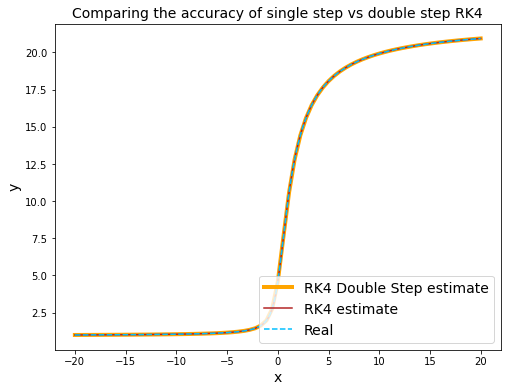

Using the double step-size method, we can achieve and accuracy which is 36.57 times better than the single step method with the same number of function calls.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor

#defining the ODE
def func(x,y):
    dydx = y/(1+x**2)
    return dydx

#Original RK4 function
def rk4_step(fun,x,y,h):
    k1 = fun(x,y)*h
    k2 = h*fun(x+h/2,y+k1/2)
    k3 = h*fun(x+h/2,y+k2/2)
    k4 = h*fun(x+h,y+k3)
    dy = (k1+2*k2+2*k3+k4)/6
    return y+dy

#Double step RK4 function
def rk4_stepd(fun,x,y,h):
    #single step
    k1 = fun(x,y)*h
    k2 = h*fun(x+h/2,y+k1/2)
    k3 = h*fun(x+h/2,y+k2/2)
    k4 = h*fun(x+h,y+k3)
    dy = (k1+2*k2+2*k3+k4)/6
    single = y+dy
    
    #RK4 from our original point, but with a half-step size
    h2=h/2 #half step size
    k12 = k1/2 #reusing the same k1, but now halved
    k22 = h2*fun(x+h2/2,y+k12/2) #the rest is the same as
    k32 = h2*fun(x+h2/2,y+k22/2) #the normal RK4, but using
    k42 = h2*fun(x+h2,y+k32)     #our new k1 and h/2
    dy2 = (k12+2*k22+2*k32+k42)/6
    y2 = y+dy2
    
    #RK4 starting from the half-step point and taking another
    #half step
    x2=x+h2 #shifting the starting point to the point after
            #taking a half step
    k13 = fun(x2,y2)*h2
    k23 = h2*fun(x2+h2/2,y2+k13/2)
    k33 = h2*fun(x2+h2/2,y2+k23/2)
    k43 = h2*fun(x2+h2,y2+k33)
    dy3 = (k13+2*k23+2*k33+k43)/6
    double = y2+dy3
    
    return double + (double-single)/15

#Comparing the 2 functions

#initial condition
y0=1
steps=200

#To get the same number of function calls for the single and
#double step RK4 functions, we need to multiply the number of
#steps in the single step function by 4/11. This is because
#double step rk4 has 11 function calls whereas single step
#only has 4 function calls
dsteps=floor((4/11)*steps)
xs=np.linspace(-20,20,steps+1)
xd=np.linspace(-20,20,dsteps+1)
hs=(max(xs)-min(xs))/steps
hd=(max(xd)-min(xd))/dsteps
ys=np.zeros(len(xs))
yd=np.zeros(len(xd))
ys[0]=y0
yd[0]=y0

#using the functions to generate points for the integral
#of our ODE
for i in range(len(xs)-1):
    ys[i+1]=rk4_step(func,xs[i],ys[i],hs)
    
for i in range(len(xd)-1):
    yd[i+1]=rk4_stepd(func,xd[i],yd[i],hd)

#Analytical solution
c0 = 1/(np.exp(np.arctan(-20)))
reals = c0*np.exp(np.arctan(xs))
reald = c0*np.exp(np.arctan(xd))

#plotting
plt.figure(figsize=(8,6))
plt.title('Comparing the accuracy of single step vs double step RK4', fontsize=14)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.plot(xd,yd, color='orange', label='RK4 Double Step estimate', linewidth=4)
plt.plot(xs,ys, color='firebrick', label='RK4 estimate')
plt.plot(xs,reals, color='deepskyblue', linestyle='--', label='Real')
plt.legend(fontsize=14, loc='lower right')
plt.show()

#error in the single vs double step method
errs = np.mean(np.abs(reals-ys))
errd = np.mean(np.abs(reald-yd))
ratio = round(errs/errd,2)

print('Using the double step-size method, we can achieve and accuracy which is {} times better than the single step method with the same number of function calls.'.format(ratio))

Math for the double step:

If set h as the half step, then to calculate y(x+2h), we can compare a single step to a double step:

Single step: $y(x+2h) = y_1 + (2h)^5 \phi + O(h^6) + ...$

Double step: $y(x+2h) = y_2 + 2(h)^5 \phi + O(h^6) + ...$

Now, if we ignore terms of order $h^6$ and higher, we can use the two equations above to improve our estimate of the true solution $y(x+2h)$:

$y(x+2h) = y_2 + \frac{y_2-y_1}{15} + O(h^6)$

which is now accurate to fifth order, one higher than our normal RK4. This method uses 11 function calls however compared to the mere 4 from our original RK4. But even with equalized function calls, this double step RK4 method is still much more accurate than our original method, as is seen above.

### Problem 2

<div>
<img src="problems/p2.png" width="600">
</div>

Setting up the ODE:

The rate $\frac{dy}{dx}$ of decay/growth of each element in the decay of U238 is simply (rate in - rate out). The rate in is the amount of the previous element in the decay chain divided by its half life, and the rate out is the amount of the element divided by its half-life. It's difficult to word this, but it can be easily seen in the ODE equations:

Ex: Rate of Thorium 234 = $\frac{dy}{dx}_{Th234} = \frac{y_{U238}}{half-life_{U238}} - \frac{y_{Th234}}{half-life_{Th234}}$, where U238 is the element that precedes Thorium 234 in the decay chain.

There are 2 exceptions to this rate however, those being the 2 end points: U238 and Pb206. U238 is the original product, so it has no rate in and Pb206 is the end of the chain, so it has no rate out.

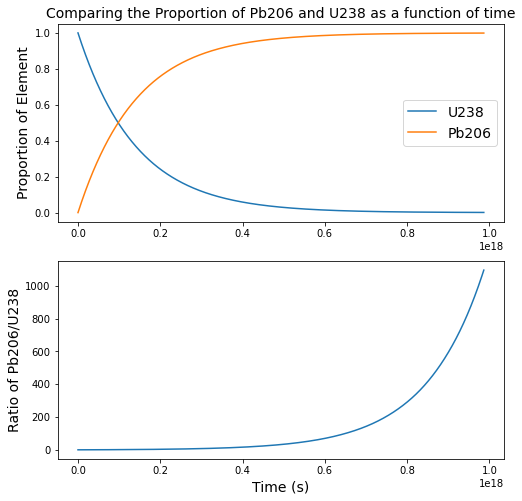

In [3]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

#creating a list with all half-lives
y=60*60*24*365
d=60*60*24
h=60*60
m=60

half_lives = np.array([4.468e9*y, 24.1*d, 6.7*h, 245500*y, 75380*y, 1600*y, 3.8235*d, 3.1*m, 26.8*m, 19.9*m, 164.3e-6, 22.3*y, 5.015*y, 138.376*d, np.inf])

#writing the ODE function
def HL_ODE(x,y,hl=half_lives):
    dydx = np.empty(len(hl))
    #initializing the edge terms
    dydx[0] = -y[0]/hl[0]
    dydx[-1] = y[-2]/hl[-2]
    #generating the rest of the terms
    for i in range(len(dydx)-1):
        dydx[i+1] = -y[i+1]/hl[i+1] + y[i]/hl[i]
    return dydx

#initialize the amounts so we start with a pure sample of uranium
y = np.zeros(len(half_lives))
y[0] = 1 

#use Radau because we have a stiff system of equations
ans = integrate.solve_ivp(HL_ODE, [0,half_lives[0]*7], y, t_eval=np.linspace(0, half_lives[0]*7,1000001), method='Radau')
#you can change the t_eval if you plan to run the code, I just have it high to
#provide better resolution for thorium230 vs U234

#Pb206 vs U238
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.title('Comparing the Proportion of Pb206 and U238 as a function of time', fontsize=14)
plt.plot(ans.t, ans.y[0], label='U238')
plt.plot(ans.t, ans.y[-1], label='Pb206')
plt.ylabel('Proportion of Element', fontsize=14)
plt.legend(fontsize=14)
plt.subplot(2,1,2)
plt.plot(ans.t, ans.y[-1]/ans.y[0])
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Ratio of Pb206/U238', fontsize=14)
plt.show()

The above plots do make sense analytically. We would expect the amount of Pb206 to rise proportionately to the amount of U238 since these are the beginning and end products respectively of our decay, and this is indeed what we can see in the first graph. The ratio of $\frac{Pb206}{U238}$ rises faster and faster as time goes on, which is what we expect as the amount of U238 slowly decays to 0 and the amount of Pb206 rises towards an asymptote.

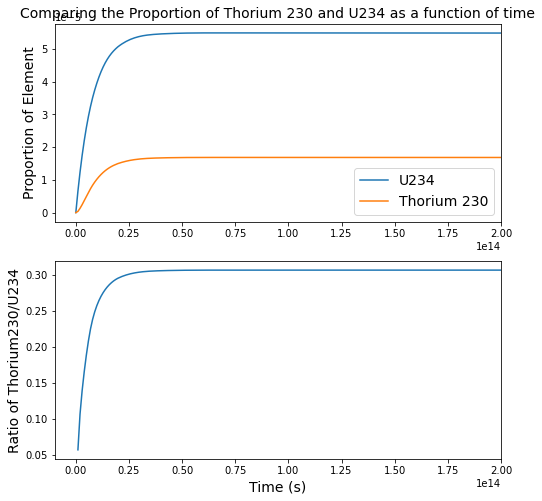

In [5]:
#Thorium 230 vs U234
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.title('Comparing the Proportion of Thorium 230 and U234 as a function of time', fontsize=14)
plt.plot(ans.t, ans.y[3], label='U234')
plt.plot(ans.t, ans.y[4], label='Thorium 230')
plt.xlim(-1e13, 0.2e15)
plt.ylabel('Proportion of Element', fontsize=14)
plt.legend(fontsize=14)
plt.subplot(2,1,2)
plt.plot(ans.t[1:], ans.y[4][1:]/ans.y[3][1:]) #first term is 0
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Ratio of Thorium230/U234', fontsize=14)
plt.xlim(-1e13, 0.2e15)
plt.show()

### Problem 3

<div>
<img src="problems/p3.png" width="600">
</div>

Text(0.5, 0, 'z')

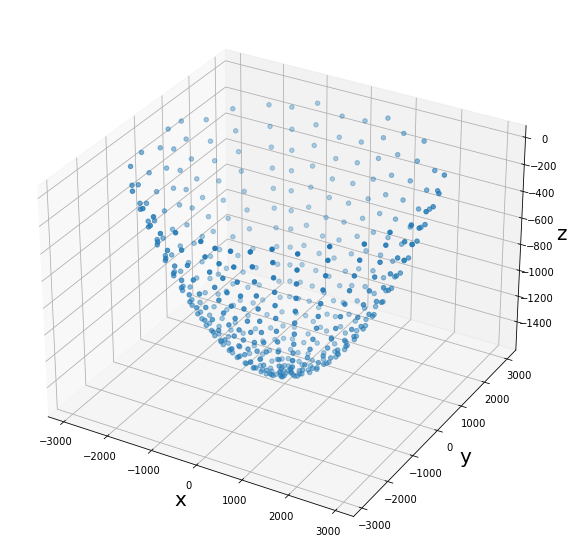

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as a3d

dish = np.loadtxt('dish_zenith.txt')
x = dish[:,0]
y = dish[:,1]
z = dish[:,2]

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
ax.scatter(x, y, z)
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.set_zlabel('z', fontsize=20)

Making the problem linear:

We start out with our equation for our paraboloid: 

$z-z_0 = a((x-x_0)^2+(y-y_0)^2)$

By sending $z_0$ to the RHS, evaluating the square and multiplying $a$ through the parentheses, we get:

$z = (a)x^2+(a)y^2+(-2ax_0)x+(-2ay_0)y+(ax_0^2+ay_0^2+z_0)$

We can now reparametrize our equation and end up with linear coefficients:

$z = A(x^2+y^2)+Bx+Cy+D$, where $A=a, B=-2ax_0, C=-2ay_0, D=ax_0^2+ay_0^2+z_0$.

In [3]:
#Creating A
A = np.empty([len(dish[:,0]), 4])

A[:,0] = 1
A[:,1] = x
A[:,2] = y
A[:,3] = x**2+y**2

LHS = A.T@A
RHS = A.T@z

mfit = np.linalg.inv(LHS)@RHS
pred = A@mfit

In [4]:
#Converting back to our original parameters
a = mfit[-1]
x0 = -mfit[-3]/(2*a)
y0 = -mfit[-2]/(2*a)
z0 = mfit[0]-a*(x0**2+y0**2)

print('Our best fit parameters are: \n a = {} \n x0 = {} \n y0 = {} \n z0 = {}'.format(a, x0, y0, z0))

Our best fit parameters are: 
 a = 0.0001667044547740124 
 x0 = -1.3604886221971237 
 y0 = 58.221476081579574 
 z0 = -1512.8772100367826


Math to calculate the focal length $f$:

We know that the equation for a parabola that goes through (0,0) can be written as $y=\frac{x^2}{4f}$, where f is the focal length. We can expand this to a paraboloid to obtain the equation $z=\frac{x^2+y^2}{4f}$ for a paraboloid passing through (0,0,0). Since we are only interested in calculating the focal length and the focal length doesn't change when you move the paraboloid in 3d space, we can recenter our paraboloid to obtain the equation $z=a(x^2+y^2)$. By equating our 2 functions for $z$, we obtain a relation between the focal length and our parameter $a$: $f=\frac{1}{4a}$.

From the residuals between the fit and our data, we can estimate the noise to be 27.95mm.
By taking the square root of the diagonal of the noise matrix N, we can estimate the uncertainty in 'a' to be 1.7e-08mm.
The calculated focal length given by our fit is f=1499.66±0.15mm.


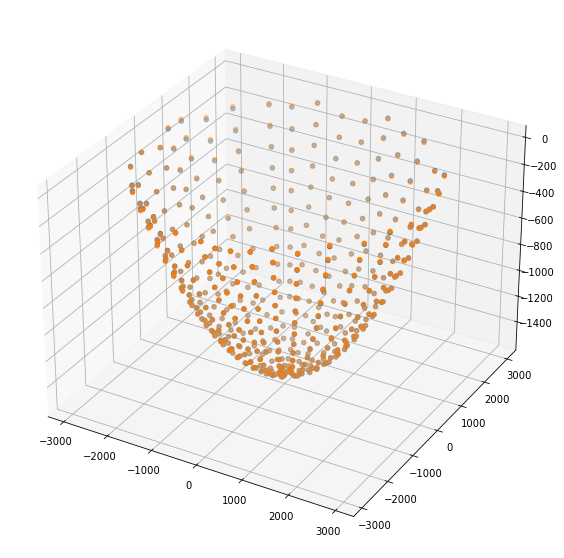

In [35]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
ax.scatter(x, y, z)
ax.scatter(x, y, pred)

#noise
fit = a*((x-x0)**2+(y-y0)**2)++z0
n = np.std(fit-z) #standard deviation of residuals

#error on a
errmat = np.sqrt(np.diag(np.linalg.inv(LHS)))
erra = errmat[-1]

#calculating f
f = 1/(4*a)
#propagate error in a 
errf = 1/(4*a**2)*erra

print('From the residuals between the fit and our data, we can estimate the noise to be {}mm.'.format(round(n, 2)))
print("By taking the square root of the diagonal of the noise matrix N, we can estimate the uncertainty in 'a' to be {}mm.".format(round(erra, 9)))
print('The calculated focal length given by our fit is f={}±{}mm.'.format(round(f,2), round(errf,2)))